<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-06/Auxiliary-Classifier-GAN-(ACGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and show Data

4423680/4422102 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


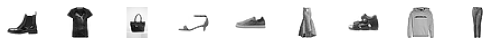

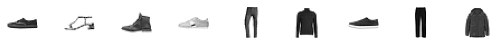

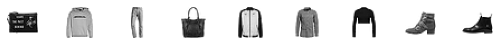

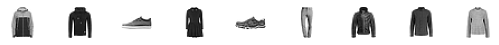

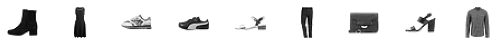

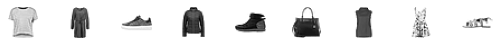

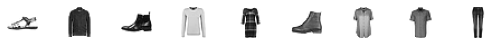

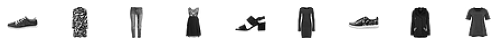

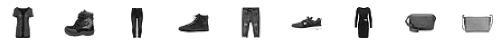

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

#  Ten classes

In [4]:
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Data Normalization

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 100)
class_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(128)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(class_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('relu')(x)


x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, class_input], outputs=generated_image)
generator_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          12928       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
______________________________________________________________________________________________

# Define Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(4,4))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

features = tensorflow.keras.layers.Flatten()(x)

d_out1 = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out1)

d_out2 = tensorflow.keras.layers.Dense(10)(features)
class_output = tensorflow.keras.layers.Activation('softmax')(d_out2)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=[real_vs_fake_output, class_output])

print (discriminator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 128)  1280        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 13, 13, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 128)    147584      leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer,\
                              metrics=['accuracy'], loss_weights=[0.5, 0.5])

# Define combined Model: AC-GAN

In [9]:
discriminator_network.trainable=False

g_output = generator_network([random_input, class_input])

d_output = discriminator_network(g_output)

ac_gan_model = tensorflow.keras.models.Model(inputs = [random_input, class_input], outputs=d_output)
ac_gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28, 1)    649377      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 1), (None, 1 561675      model[0][0]                

# Compiling ACGAN

In [10]:
ac_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer)

# Define Data Generators

In [11]:
indices = [i for i in range(0, len(trainX))]

def encode_class_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_class_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    class_inputs = []
    for i in range(batch_size):
        class_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        class_inputs.append(encode_class_input(class_input))
    class_inputs = np.array(class_inputs)
    return random_noise_batches, class_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, class_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_inputs])
    return fake_samples, class_inputs

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    real_classes = np.array([encode_class_input(x) for x in trainY[np.array(random_indices),]])
    return real_images, real_classes

def show_generator_results(generator_network):
    for k in range(10):
        random_noise_batches, _ = get_random_noise(10, noise_size) 
        class_inputs = []
        for bs in range(10):
            class_inputs.append(encode_class_input(k))
        class_inputs = np.array(class_inputs)

        fake_samples = generator_network.predict_on_batch([random_noise_batches, class_inputs])
        plt.figure(figsize=(9, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(decode_class_input(class_inputs[i]))
        plt.show()
    return

# Training AC-GAN

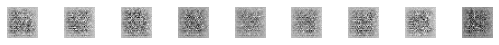

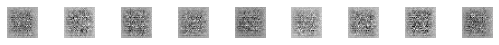

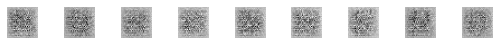

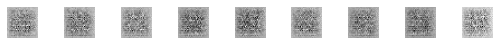

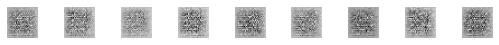

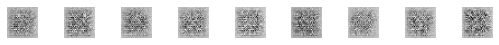

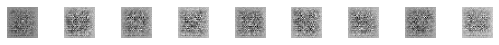

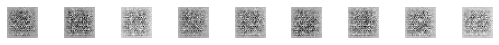

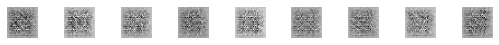

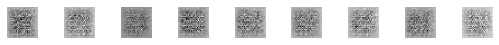

Epoch:0, Step:0, D-Loss:1.833, D-Acc:25.000, D-Acc-Classification:14.000, G-Loss:2.978
Epoch:0, Step:50, D-Loss:0.861, D-Acc:96.000, D-Acc-Classification:43.000, G-Loss:5.147
Epoch:0, Step:100, D-Loss:0.744, D-Acc:92.000, D-Acc-Classification:56.000, G-Loss:4.786
Epoch:0, Step:150, D-Loss:0.601, D-Acc:93.000, D-Acc-Classification:64.000, G-Loss:4.144
Epoch:0, Step:200, D-Loss:0.516, D-Acc:87.000, D-Acc-Classification:76.000, G-Loss:3.450
Epoch:0, Step:250, D-Loss:0.361, D-Acc:93.000, D-Acc-Classification:84.000, G-Loss:4.271
Epoch:0, Step:300, D-Loss:0.379, D-Acc:96.000, D-Acc-Classification:77.000, G-Loss:4.378
Epoch:0, Step:350, D-Loss:0.300, D-Acc:93.000, D-Acc-Classification:83.000, G-Loss:2.850
Epoch:0, Step:400, D-Loss:0.303, D-Acc:95.000, D-Acc-Classification:87.000, G-Loss:3.212
Epoch:0, Step:450, D-Loss:0.269, D-Acc:98.000, D-Acc-Classification:88.000, G-Loss:5.276
Epoch:1, Step:0, D-Loss:0.318, D-Acc:90.000, D-Acc-Classification:87.000, G-Loss:2.484
Epoch:1, Step:50, D-Loss:0

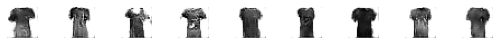

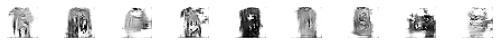

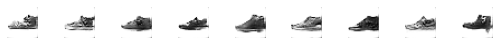

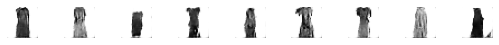

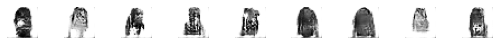

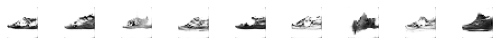

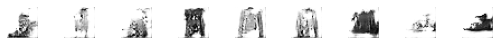

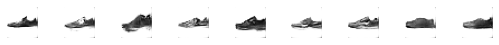

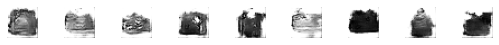

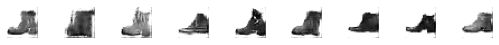

Epoch:5, Step:0, D-Loss:0.240, D-Acc:90.000, D-Acc-Classification:92.000, G-Loss:2.150
Epoch:5, Step:50, D-Loss:0.275, D-Acc:86.000, D-Acc-Classification:92.000, G-Loss:1.970
Epoch:5, Step:100, D-Loss:0.244, D-Acc:89.000, D-Acc-Classification:94.000, G-Loss:2.184
Epoch:5, Step:150, D-Loss:0.261, D-Acc:82.000, D-Acc-Classification:97.000, G-Loss:1.980
Epoch:5, Step:200, D-Loss:0.308, D-Acc:84.000, D-Acc-Classification:91.000, G-Loss:2.190
Epoch:5, Step:250, D-Loss:0.206, D-Acc:89.000, D-Acc-Classification:94.000, G-Loss:1.979
Epoch:5, Step:300, D-Loss:0.312, D-Acc:82.000, D-Acc-Classification:90.000, G-Loss:2.226
Epoch:5, Step:350, D-Loss:0.296, D-Acc:85.000, D-Acc-Classification:91.000, G-Loss:2.578
Epoch:5, Step:400, D-Loss:0.399, D-Acc:77.000, D-Acc-Classification:92.000, G-Loss:1.740
Epoch:5, Step:450, D-Loss:0.258, D-Acc:86.000, D-Acc-Classification:95.000, G-Loss:2.201
Epoch:6, Step:0, D-Loss:0.324, D-Acc:83.000, D-Acc-Classification:91.000, G-Loss:1.973
Epoch:6, Step:50, D-Loss:0

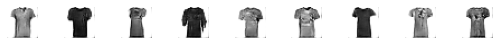

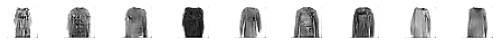

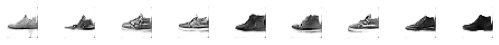

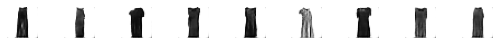

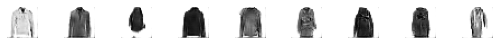

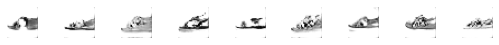

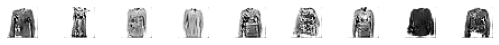

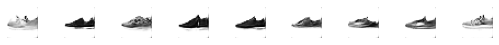

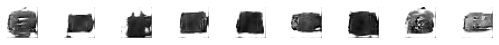

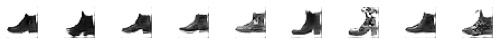

Epoch:10, Step:0, D-Loss:0.267, D-Acc:83.000, D-Acc-Classification:96.000, G-Loss:1.981
Epoch:10, Step:50, D-Loss:0.266, D-Acc:85.000, D-Acc-Classification:95.000, G-Loss:1.521
Epoch:10, Step:100, D-Loss:0.309, D-Acc:84.000, D-Acc-Classification:92.000, G-Loss:1.637
Epoch:10, Step:150, D-Loss:0.279, D-Acc:79.000, D-Acc-Classification:95.000, G-Loss:1.896
Epoch:10, Step:200, D-Loss:0.294, D-Acc:79.000, D-Acc-Classification:97.000, G-Loss:1.617
Epoch:10, Step:250, D-Loss:0.299, D-Acc:78.000, D-Acc-Classification:95.000, G-Loss:1.374
Epoch:10, Step:300, D-Loss:0.314, D-Acc:79.000, D-Acc-Classification:93.000, G-Loss:1.874
Epoch:10, Step:350, D-Loss:0.279, D-Acc:79.000, D-Acc-Classification:95.000, G-Loss:1.717
Epoch:10, Step:400, D-Loss:0.262, D-Acc:79.000, D-Acc-Classification:96.000, G-Loss:1.329
Epoch:10, Step:450, D-Loss:0.265, D-Acc:77.000, D-Acc-Classification:97.000, G-Loss:1.546
Epoch:11, Step:0, D-Loss:0.322, D-Acc:77.000, D-Acc-Classification:95.000, G-Loss:1.338
Epoch:11, Step:

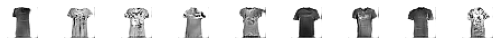

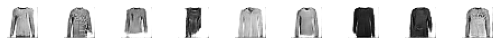

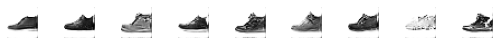

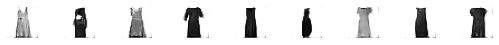

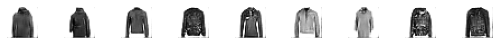

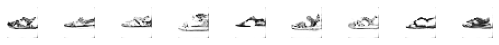

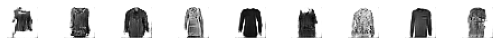

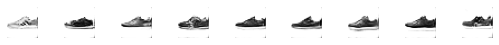

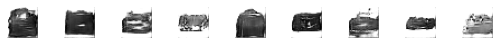

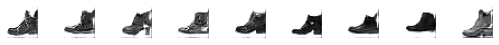

Epoch:15, Step:0, D-Loss:0.366, D-Acc:76.000, D-Acc-Classification:89.000, G-Loss:1.523
Epoch:15, Step:50, D-Loss:0.272, D-Acc:82.000, D-Acc-Classification:97.000, G-Loss:1.939
Epoch:15, Step:100, D-Loss:0.284, D-Acc:80.000, D-Acc-Classification:96.000, G-Loss:1.312
Epoch:15, Step:150, D-Loss:0.355, D-Acc:75.000, D-Acc-Classification:91.000, G-Loss:1.637
Epoch:15, Step:200, D-Loss:0.284, D-Acc:74.000, D-Acc-Classification:94.000, G-Loss:1.328
Epoch:15, Step:250, D-Loss:0.296, D-Acc:73.000, D-Acc-Classification:97.000, G-Loss:1.448
Epoch:15, Step:300, D-Loss:0.319, D-Acc:71.000, D-Acc-Classification:97.000, G-Loss:1.352
Epoch:15, Step:350, D-Loss:0.365, D-Acc:80.000, D-Acc-Classification:93.000, G-Loss:1.222
Epoch:15, Step:400, D-Loss:0.230, D-Acc:86.000, D-Acc-Classification:96.000, G-Loss:1.576
Epoch:15, Step:450, D-Loss:0.397, D-Acc:68.000, D-Acc-Classification:94.000, G-Loss:1.406
Epoch:16, Step:0, D-Loss:0.343, D-Acc:78.000, D-Acc-Classification:94.000, G-Loss:1.356
Epoch:16, Step:

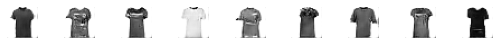

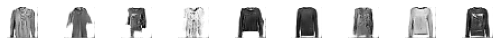

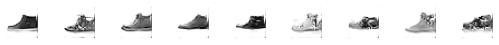

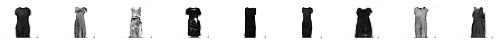

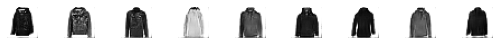

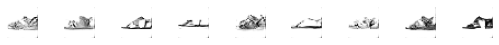

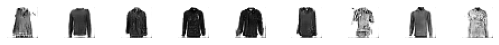

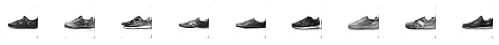

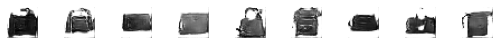

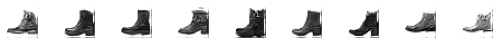

Epoch:20, Step:0, D-Loss:0.256, D-Acc:76.000, D-Acc-Classification:98.000, G-Loss:1.611
Epoch:20, Step:50, D-Loss:0.344, D-Acc:73.000, D-Acc-Classification:93.000, G-Loss:1.135
Epoch:20, Step:100, D-Loss:0.309, D-Acc:75.000, D-Acc-Classification:95.000, G-Loss:1.351
Epoch:20, Step:150, D-Loss:0.349, D-Acc:75.000, D-Acc-Classification:95.000, G-Loss:1.617
Epoch:20, Step:200, D-Loss:0.347, D-Acc:71.000, D-Acc-Classification:99.000, G-Loss:1.230
Epoch:20, Step:250, D-Loss:0.319, D-Acc:75.000, D-Acc-Classification:95.000, G-Loss:1.491
Epoch:20, Step:300, D-Loss:0.304, D-Acc:80.000, D-Acc-Classification:96.000, G-Loss:1.408
Epoch:20, Step:350, D-Loss:0.322, D-Acc:69.000, D-Acc-Classification:96.000, G-Loss:1.261
Epoch:20, Step:400, D-Loss:0.302, D-Acc:76.000, D-Acc-Classification:98.000, G-Loss:1.341
Epoch:20, Step:450, D-Loss:0.257, D-Acc:84.000, D-Acc-Classification:96.000, G-Loss:1.492
Epoch:21, Step:0, D-Loss:0.342, D-Acc:70.000, D-Acc-Classification:96.000, G-Loss:1.346
Epoch:21, Step:

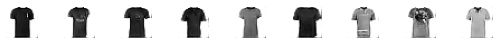

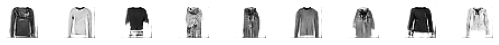

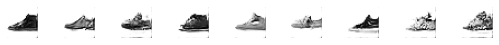

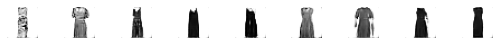

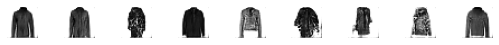

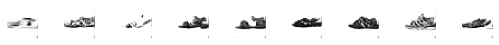

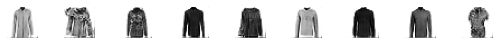

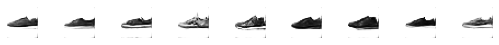

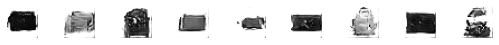

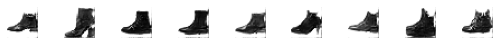

Epoch:25, Step:0, D-Loss:0.278, D-Acc:79.000, D-Acc-Classification:95.000, G-Loss:1.448
Epoch:25, Step:50, D-Loss:0.359, D-Acc:62.000, D-Acc-Classification:99.000, G-Loss:1.021
Epoch:25, Step:100, D-Loss:0.327, D-Acc:77.000, D-Acc-Classification:95.000, G-Loss:1.232
Epoch:25, Step:150, D-Loss:0.306, D-Acc:75.000, D-Acc-Classification:98.000, G-Loss:1.462
Epoch:25, Step:200, D-Loss:0.269, D-Acc:80.000, D-Acc-Classification:95.000, G-Loss:1.229
Epoch:25, Step:250, D-Loss:0.279, D-Acc:84.000, D-Acc-Classification:98.000, G-Loss:1.428
Epoch:25, Step:300, D-Loss:0.337, D-Acc:80.000, D-Acc-Classification:94.000, G-Loss:1.412
Epoch:25, Step:350, D-Loss:0.329, D-Acc:72.000, D-Acc-Classification:94.000, G-Loss:1.699
Epoch:25, Step:400, D-Loss:0.352, D-Acc:72.000, D-Acc-Classification:96.000, G-Loss:1.449
Epoch:25, Step:450, D-Loss:0.314, D-Acc:74.000, D-Acc-Classification:94.000, G-Loss:1.666
Epoch:26, Step:0, D-Loss:0.360, D-Acc:73.000, D-Acc-Classification:93.000, G-Loss:1.287
Epoch:26, Step:

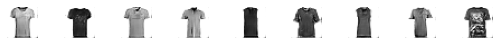

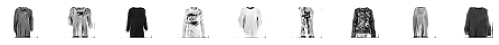

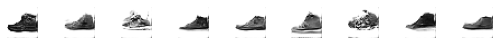

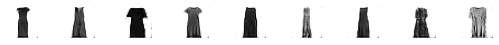

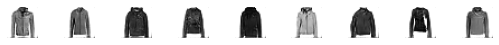

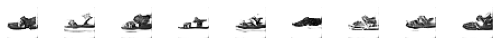

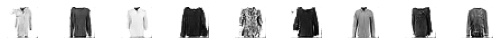

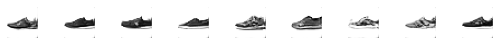

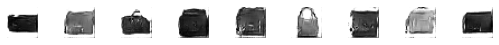

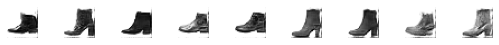

Epoch:30, Step:0, D-Loss:0.297, D-Acc:85.000, D-Acc-Classification:92.000, G-Loss:1.467
Epoch:30, Step:50, D-Loss:0.239, D-Acc:81.000, D-Acc-Classification:100.000, G-Loss:1.427
Epoch:30, Step:100, D-Loss:0.307, D-Acc:67.000, D-Acc-Classification:98.000, G-Loss:1.550
Epoch:30, Step:150, D-Loss:0.308, D-Acc:71.000, D-Acc-Classification:95.000, G-Loss:1.539
Epoch:30, Step:200, D-Loss:0.285, D-Acc:73.000, D-Acc-Classification:98.000, G-Loss:1.560
Epoch:30, Step:250, D-Loss:0.301, D-Acc:78.000, D-Acc-Classification:95.000, G-Loss:1.060
Epoch:30, Step:300, D-Loss:0.315, D-Acc:76.000, D-Acc-Classification:96.000, G-Loss:1.345
Epoch:30, Step:350, D-Loss:0.317, D-Acc:70.000, D-Acc-Classification:96.000, G-Loss:1.439
Epoch:30, Step:400, D-Loss:0.283, D-Acc:73.000, D-Acc-Classification:96.000, G-Loss:1.200
Epoch:30, Step:450, D-Loss:0.321, D-Acc:73.000, D-Acc-Classification:95.000, G-Loss:1.344
Epoch:31, Step:0, D-Loss:0.280, D-Acc:79.000, D-Acc-Classification:99.000, G-Loss:1.301
Epoch:31, Step

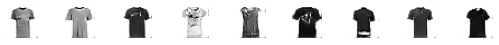

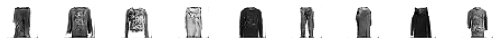

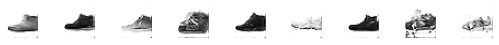

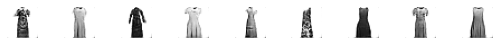

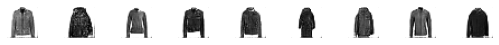

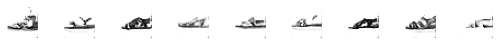

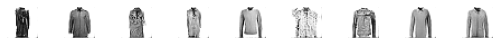

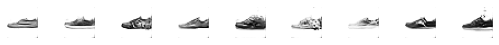

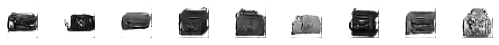

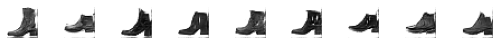

Epoch:35, Step:0, D-Loss:0.337, D-Acc:80.000, D-Acc-Classification:96.000, G-Loss:1.649
Epoch:35, Step:50, D-Loss:0.299, D-Acc:70.000, D-Acc-Classification:98.000, G-Loss:1.171
Epoch:35, Step:100, D-Loss:0.301, D-Acc:72.000, D-Acc-Classification:99.000, G-Loss:1.287
Epoch:35, Step:150, D-Loss:0.302, D-Acc:74.000, D-Acc-Classification:96.000, G-Loss:1.413
Epoch:35, Step:200, D-Loss:0.306, D-Acc:74.000, D-Acc-Classification:97.000, G-Loss:1.247
Epoch:35, Step:250, D-Loss:0.342, D-Acc:70.000, D-Acc-Classification:96.000, G-Loss:1.257
Epoch:35, Step:300, D-Loss:0.240, D-Acc:78.000, D-Acc-Classification:99.000, G-Loss:1.336
Epoch:35, Step:350, D-Loss:0.265, D-Acc:81.000, D-Acc-Classification:99.000, G-Loss:1.117
Epoch:35, Step:400, D-Loss:0.328, D-Acc:71.000, D-Acc-Classification:96.000, G-Loss:1.187
Epoch:35, Step:450, D-Loss:0.316, D-Acc:74.000, D-Acc-Classification:94.000, G-Loss:1.663
Epoch:36, Step:0, D-Loss:0.278, D-Acc:76.000, D-Acc-Classification:99.000, G-Loss:1.829
Epoch:36, Step:

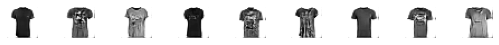

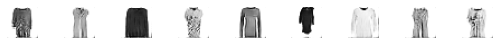

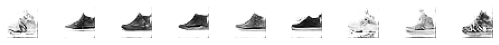

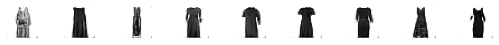

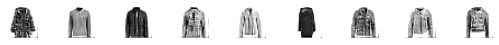

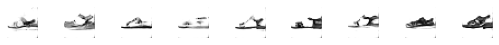

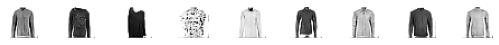

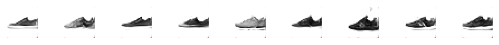

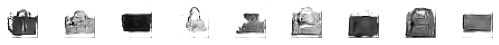

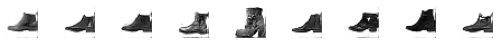

Epoch:40, Step:0, D-Loss:0.303, D-Acc:73.000, D-Acc-Classification:96.000, G-Loss:1.142
Epoch:40, Step:50, D-Loss:0.389, D-Acc:71.000, D-Acc-Classification:94.000, G-Loss:1.260
Epoch:40, Step:100, D-Loss:0.291, D-Acc:72.000, D-Acc-Classification:96.000, G-Loss:1.554
Epoch:40, Step:150, D-Loss:0.294, D-Acc:76.000, D-Acc-Classification:95.000, G-Loss:1.080
Epoch:40, Step:200, D-Loss:0.296, D-Acc:69.000, D-Acc-Classification:97.000, G-Loss:1.381
Epoch:40, Step:250, D-Loss:0.269, D-Acc:83.000, D-Acc-Classification:98.000, G-Loss:1.545
Epoch:40, Step:300, D-Loss:0.368, D-Acc:67.000, D-Acc-Classification:95.000, G-Loss:1.398
Epoch:40, Step:350, D-Loss:0.344, D-Acc:71.000, D-Acc-Classification:92.000, G-Loss:1.355
Epoch:40, Step:400, D-Loss:0.289, D-Acc:78.000, D-Acc-Classification:98.000, G-Loss:1.248
Epoch:40, Step:450, D-Loss:0.294, D-Acc:70.000, D-Acc-Classification:98.000, G-Loss:1.668
Epoch:41, Step:0, D-Loss:0.264, D-Acc:73.000, D-Acc-Classification:97.000, G-Loss:1.387
Epoch:41, Step:

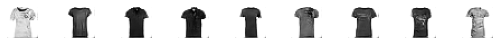

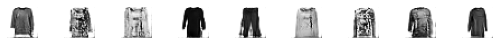

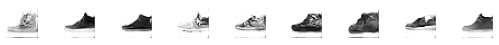

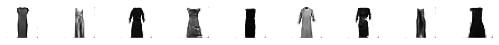

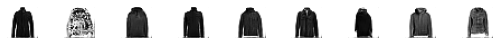

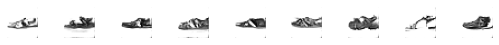

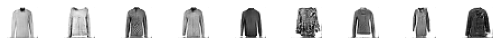

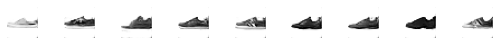

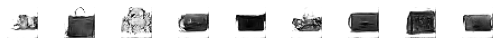

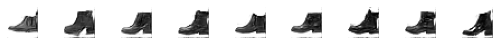

Epoch:45, Step:0, D-Loss:0.297, D-Acc:78.000, D-Acc-Classification:97.000, G-Loss:1.471
Epoch:45, Step:50, D-Loss:0.272, D-Acc:82.000, D-Acc-Classification:95.000, G-Loss:1.195
Epoch:45, Step:100, D-Loss:0.344, D-Acc:72.000, D-Acc-Classification:94.000, G-Loss:1.379
Epoch:45, Step:150, D-Loss:0.336, D-Acc:73.000, D-Acc-Classification:94.000, G-Loss:1.411
Epoch:45, Step:200, D-Loss:0.271, D-Acc:72.000, D-Acc-Classification:100.000, G-Loss:1.177
Epoch:45, Step:250, D-Loss:0.277, D-Acc:78.000, D-Acc-Classification:99.000, G-Loss:1.567
Epoch:45, Step:300, D-Loss:0.294, D-Acc:76.000, D-Acc-Classification:97.000, G-Loss:1.214
Epoch:45, Step:350, D-Loss:0.322, D-Acc:66.000, D-Acc-Classification:97.000, G-Loss:1.327
Epoch:45, Step:400, D-Loss:0.338, D-Acc:69.000, D-Acc-Classification:93.000, G-Loss:1.157
Epoch:45, Step:450, D-Loss:0.326, D-Acc:72.000, D-Acc-Classification:96.000, G-Loss:1.449
Epoch:46, Step:0, D-Loss:0.297, D-Acc:71.000, D-Acc-Classification:98.000, G-Loss:1.426
Epoch:46, Step

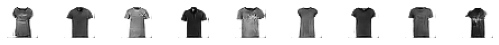

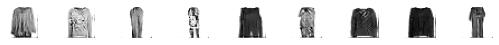

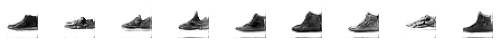

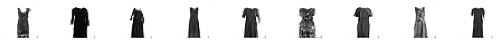

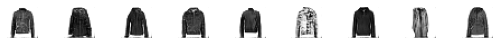

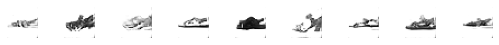

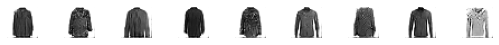

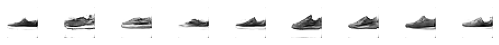

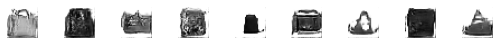

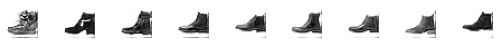

Epoch:50, Step:0, D-Loss:0.383, D-Acc:69.000, D-Acc-Classification:95.000, G-Loss:1.465
Epoch:50, Step:50, D-Loss:0.236, D-Acc:80.000, D-Acc-Classification:99.000, G-Loss:1.754
Epoch:50, Step:100, D-Loss:0.279, D-Acc:75.000, D-Acc-Classification:97.000, G-Loss:1.256
Epoch:50, Step:150, D-Loss:0.296, D-Acc:73.000, D-Acc-Classification:94.000, G-Loss:1.410
Epoch:50, Step:200, D-Loss:0.290, D-Acc:72.000, D-Acc-Classification:99.000, G-Loss:1.674
Epoch:50, Step:250, D-Loss:0.272, D-Acc:76.000, D-Acc-Classification:98.000, G-Loss:1.229


KeyboardInterrupt: ignored

In [12]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%5 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples, fake_classes = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples, real_classes = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        class_labels = np.vstack((fake_classes, real_classes))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, [output_labels, class_labels])
        
        noise_batches, class_inputs = get_random_noise(batch_size, noise_size)
        ac_gan_input = [noise_batches, class_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        
        ac_gan_output = [d_output, class_inputs]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = ac_gan_model.train_on_batch(ac_gan_input, ac_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, D-Acc-Classification:%.3f, G-Loss:%.3f"%\
                   (i,j,loss_d[0],loss_d[3]*100,loss_d[4]*100,loss_g[0]))
            

# Results

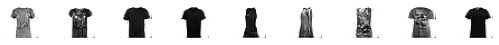

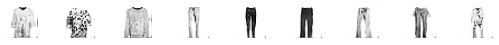

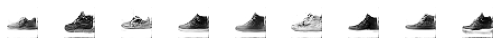

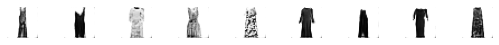

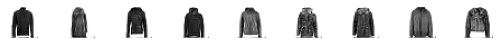

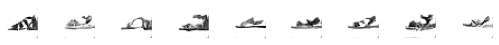

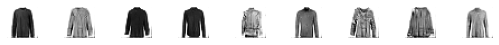

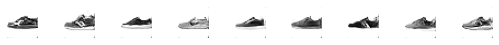

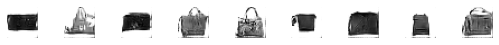

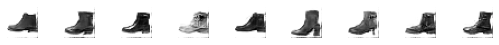

----------------------------------------------------------------------------------------------------


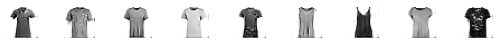

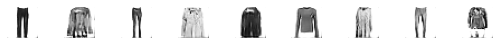

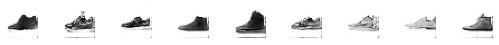

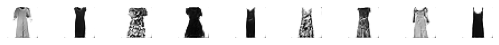

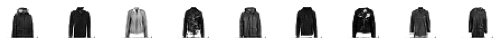

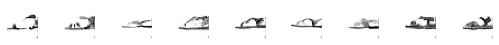

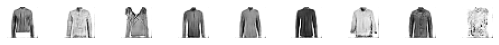

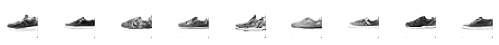

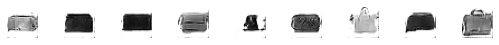

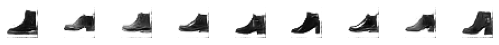

----------------------------------------------------------------------------------------------------


In [13]:
for i in range(2):
    show_generator_results(generator_network)
    print("-"*100)